In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.nn.models import GIN
from gpytorch.priors import NormalPrior
from gpytorch.kernels import RBFKernel
from torch_geometric.nn import global_mean_pool

from mobius import Planner, SequenceGA
from mobius import Graph, GPGNNModel, ExpectedImprovement
from mobius import LinearPeptideEmulator
from mobius import homolog_scanning, alanine_scanning
from mobius import convert_FASTA_to_HELM

# Initialize MHC emulator

In [4]:
pssm_files = ['../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-8.txt',
              '../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-9.txt',
              '../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-10.txt',
              '../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-11.txt']
lpe = LinearPeptideEmulator(pssm_files)

# Define lead peptide and create initial peptide batch

In [5]:
lead_peptide = convert_FASTA_to_HELM('HMTEVVRRC')[0]

In [6]:
seed_library = [lead_peptide]

for seq in alanine_scanning(lead_peptide):
    seed_library.append(seq)

for seq in homolog_scanning(lead_peptide):
    seed_library.append(seq)

    if len(seed_library) >= 96:
        print('Reach max. number of peptides allowed.')
        break

Reach max. number of peptides allowed.


In [7]:
pic50_seed_library = lpe.score(seed_library)

# Define Gaussian Process, acquisition function and GA optimizer

In [8]:
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GNNModel, self).__init__()

        self.model = GIN(in_channels=in_channels, hidden_channels=hidden_channels, num_layers=num_layers, out_channels=out_channels, dropout=dropout)
        
        self._reset_parameters()

    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""

        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, x):
        node_attr, edge_index, edge_attr, batch = x.node_attr, x.edge_index, x.edge_attr, x.batch
        x = self.model(x=node_attr, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        x = global_mean_pool(x, batch)

        return x

In [9]:
graph_convertor = Graph(input_type='helm', output_type='pyg')

In [10]:
graphs = graph_convertor.transform(lead_peptide)
gnn = GNNModel(in_channels=graphs.node_attr.shape[1], hidden_channels=256, out_channels=256, num_layers=4, dropout=0.25)

In [11]:
gpmodel = GPGNNModel(kernel=RBFKernel(), model=gnn, transform=graph_convertor, noise_prior=NormalPrior(loc=0, scale=1))

In [12]:
yaml_content = """
design:
  monomers:
    default: [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]
    APOLAR: [A, F, G, I, L, P, V, W]
    POLAR: [C, D, E, H, K, N, Q, R, K, S, T, M]
    AROMATIC: [F, H, W, Y]
    POS_CHARGED: [K, R]
    NEG_CHARGED: [D, E]
  polymers:
    - PEPTIDE1{X.M.X.X.X.X.X.X.X}$$$$V2.0:
        PEPTIDE1:
          1: [AROMATIC, NEG_CHARGED]
          4: POLAR
          9: [A, V, I, L, M, T]
filters:
  - class_path: mobius.PeptideSelfAggregationFilter
  - class_path: mobius.PeptideSolubilityFilter
    init_args:
      hydrophobe_ratio: 0.5
      charged_per_amino_acids: 5
"""

with open('design_protocol.yaml', 'w') as f:
    f.write(yaml_content)

In [13]:
ei = ExpectedImprovement(gpmodel, maximize=False)
optimizer = SequenceGA(algorithm='GA', period=15, n_pop=500, design_protocol_filename='design_protocol.yaml')
ps = Planner(ei, optimizer)

# Run optimization!

In [14]:
peptides = seed_library.copy()
pic50_scores = pic50_seed_library.copy()

# Store data for later analysis
data = [(0, p, s) for p, s in zip(peptides, pic50_scores)]

for i in range(3):
    suggested_peptides, _ = ps.recommend(peptides, pic50_scores.reshape(-1, 1), batch_size=96)

    # Here you can add whatever methods you want to further filter out peptides

    # Virtually test the suggested peptides using the MHC emulator
    # You know the drill now, this is for benchmarking or demonstration
    # purposes only and should be replaced with actual lab experiments.
    pic50_suggested_peptides = lpe.score(suggested_peptides)

    peptides = np.concatenate([peptides, suggested_peptides])
    pic50_scores = np.concatenate((pic50_scores, pic50_suggested_peptides), axis=0)
    data.extend([(i + 1, p, s) for p, s in zip(suggested_peptides, pic50_suggested_peptides)])

    best_seq = peptides[np.argmin(pic50_scores)]
    best_pic50 = np.min(pic50_scores)
    print('Best peptide found so far: %s / %.3f' % (best_seq, best_pic50))
    print('')

df = pd.DataFrame(data=data, columns=('iter', 'polymer', 'exp_value'))

Fitting GPGNN model (cpu): 10step [00:05,  1.96step/s, loss=1.06]


n_gen  |  n_eval  |     cv_min    |     cv_avg    |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  0.000000E+00 |  0.1428571429 |  8.63289030303030280 |  7.16085999999999956 |      PEPTIDE1{H.M.T.E.V.V.R.R.V}$$$$V2.0
     2 |      500 |  0.000000E+00 |  0.0380000000 |  1.18437633877007320 | -5.1026875012989E-03 |      PEPTIDE1{E.M.Y.E.R.S.R.R.A}$$$$V2.0
     3 |     1000 |  0.000000E+00 |  0.000000E+00 | -5.4047115435575E-04 | -8.1498524253159E-03 |      PEPTIDE1{E.M.G.K.A.V.G.R.A}$$$$V2.0
     4 |     1500 |  0.000000E+00 |  0.000000E+00 | -1.3956728018870E-03 | -1.4248674470108E-02 |      PEPTIDE1{E.M.L.E.K.Q.Q.R.A}$$$$V2.0
     5 |     2000 |  0.000000E+00 |  0.000000E+00 | -3.2925416643967E-03 | -3.0138723841268E-02 |      PEPTIDE1{E.M.R.E.G.K.K.R.L}$$$$V2.0
     6 |     2500 |  0.000000E+00 |  0.000000E+00 | -6.5501399467074E-03 | -3.7023652139719E-02 |      PEPTIDE1{E.M.R.K.R.K.K.R.L}$$$$V2.0
     7 |     3000 |  0.0000

Fitting GPGNN model (cpu): 9step [00:09,  1.10s/step, loss=0.605]


n_gen  |  n_eval  |     cv_min    |     cv_avg    |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  0.000000E+00 |  0.0581395349 |  1.0933032839506E+01 |  8.25885999999999854 |      PEPTIDE1{H.M.T.E.V.V.R.R.V}$$$$V2.0
     2 |      500 |  0.000000E+00 |  0.000000E+00 |  1.44338389508009080 | -1.9727267765940E-01 |      PEPTIDE1{E.M.W.H.L.G.N.K.A}$$$$V2.0
     3 |     1000 |  0.000000E+00 |  0.000000E+00 | -4.4282511959982E-03 | -1.9727267765940E-01 |      PEPTIDE1{E.M.W.H.L.G.N.K.A}$$$$V2.0
     4 |     1500 |  0.000000E+00 |  0.000000E+00 | -9.5807475346516E-03 | -1.9727267765940E-01 |      PEPTIDE1{E.M.W.H.L.G.N.K.A}$$$$V2.0
     5 |     2000 |  0.000000E+00 |  0.000000E+00 | -1.9295083549351E-02 | -1.9727267765940E-01 |      PEPTIDE1{E.M.W.H.L.G.N.K.A}$$$$V2.0
     6 |     2500 |  0.000000E+00 |  0.000000E+00 | -3.8124692128507E-02 | -2.3762680280816E-01 |      PEPTIDE1{E.M.W.D.L.G.H.R.A}$$$$V2.0
     7 |     3000 |  0.0000

Fitting GPGNN model (cpu): 8step [00:15,  1.96s/step, loss=0.819]


n_gen  |  n_eval  |     cv_min    |     cv_avg    |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  0.000000E+00 |  0.0334572491 |  1.0223271538462E+01 |  7.64185999999999943 |      PEPTIDE1{E.M.F.D.G.F.F.G.L}$$$$V2.0
     2 |      500 |  0.000000E+00 |  0.000000E+00 |  1.94253752173670202 | -1.4933464567168E-04 |      PEPTIDE1{E.M.G.D.G.F.G.F.L}$$$$V2.0
     3 |     1000 |  0.000000E+00 |  0.000000E+00 | -2.0447516335111E-05 | -1.4933464567168E-04 |      PEPTIDE1{E.M.G.D.G.F.G.F.L}$$$$V2.0
     4 |     1500 |  0.000000E+00 |  0.000000E+00 | -3.9507350333109E-05 | -1.5432396002957E-04 |      PEPTIDE1{E.M.F.D.G.F.G.F.L}$$$$V2.0
     5 |     2000 |  0.000000E+00 |  0.000000E+00 | -5.9548819200100E-05 | -1.5432396002957E-04 |      PEPTIDE1{E.M.F.D.G.F.G.F.L}$$$$V2.0
     6 |     2500 |  0.000000E+00 |  0.000000E+00 | -7.3641465912250E-05 | -2.2491751916057E-04 |      PEPTIDE1{E.M.G.D.G.G.F.G.I}$$$$V2.0
     7 |     3000 |  0.0000

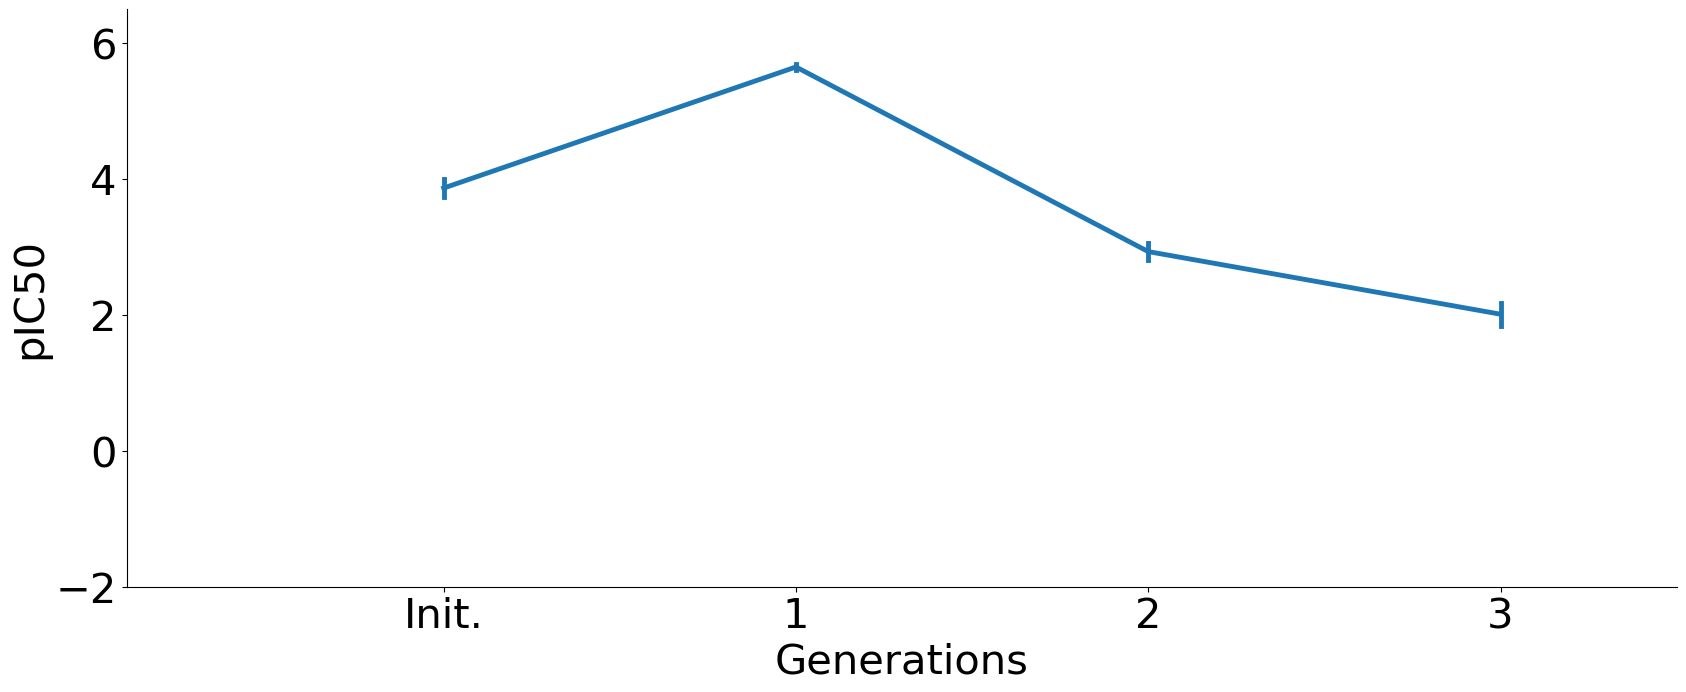

In [17]:
fig, ax = plt.subplots(figsize=(20, 7.5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3'})

sns.lineplot(x='iter', y='exp_value', data=df, ax=ax, errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax.set_xlim([-0.9, 3.5])
ax.set_ylim([-2, 6.5])
ax.set_ylabel('pIC50', fontsize=30)
ax.set_xlabel('Generations', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()